<a href="https://colab.research.google.com/github/bansallab/incarcerated_vacc/blob/main/regression_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import pandas as pd
import numpy as np
import geopandas
import statsmodels as sm
import statsmodels.api as sma
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
import os
import plotly.express as px
from google.colab import drive
import seaborn as sns

In [148]:

drive.mount('/content/drive',force_remount=True)

os.chdir('/content/drive/MyDrive/Alexes_Bansal_Lab/Prison Vaccinaiton Project/')
wd='/content/drive/MyDrive/Alexes_Bansal_Lab/Prison Vaccinaiton Project/'

Mounted at /content/drive


### CREATE DATA FILE with vaccinated/unvaccinated numbers in each state, and various covariates/predictors (prioritiezed, decarcerated, non-inc-coverage, ...)

In [149]:
states_abbrevs = {'AK':'Alaska','AL':'Alabama','AR':'Arkansas','AZ':'Arizona', 'CA':'California','CO':'Colorado',
    'CT':'Connecticut','DC':'District of Columbia','DE':'Delaware','FL':'Florida','GA':'Georgia',
    'HI':'Hawaii','IA':'Iowa','ID':'Idaho','IL':'Illinois','IN':'Indiana','KS':'Kansas','KY':'Kentucky','LA':'Louisiana',
    'MA':'Massachusetts','MD':'Maryland','ME':'Maine','MI':'Michigan','MN':'Minnesota','MO':'Missouri','MS':'Mississippi',
    'MT':'Montana','NC':'North Carolina','ND':'North Dakota','NE':'Nebraska','NH':'New Hampshire','NJ':'New Jersey',
    'NM':'New Mexico','NV':'Nevada','NY':'New York','OH':'Ohio','OK':'Oklahoma','OR':'Oregon','PA':'Pennsylvania',
    'RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota','TN':'Tennessee','TX':'Texas','UT':'Utah',
    'VA':'Virginia','VT':'Vermont','WA':'Washington','WI':'Wisconsin','WV':'West Virginia','WY':'Wyoming'}


In [150]:
state_populations_2020 = {
    "California": 39538223,
    "Texas": 29145505,
    "Florida": 21538187,
    "New York": 20201249,
    "Pennsylvania": 13002700,
    "Illinois": 12812508,
    "Ohio": 11799448,
    "Georgia": 10711908,
    "North Carolina": 10439388,
    "Michigan": 10077331,
    "New Jersey": 9288994,
    "Virginia": 8631393,
    "Washington": 7705281,
    "Arizona": 7151502,
    "Tennessee": 6910840,
    "Massachusetts": 7029917,
    "Indiana": 6785528,
    "Maryland": 6177224,
    "Missouri": 6154913,
    "Wisconsin": 5893718,
    "Colorado": 5773714,
    "Minnesota": 5706494,
    "South Carolina": 5118425,
    "Alabama": 5024279,
    "Louisiana": 4657757,
    "Kentucky": 4505836,
    "Oregon": 4237256,
    "Oklahoma": 3959353,
    "Connecticut": 3605944,
    "Utah": 3271616,
    "Nevada": 3104614,
    "Iowa": 3190369,
    "Puerto Rico": 3285874,
    "Arkansas": 3011524,
    "Kansas": 2937880,
    "Mississippi": 2961279,
    "New Mexico": 2117522,
    "Nebraska": 1961504,
    "Idaho": 1839106,
    "West Virginia": 1793716,
    "Hawaii": 1455271,
    "New Hampshire": 1377529,
    "Maine": 1362359,
    "Montana": 1084225,
    "Rhode Island": 1097379,
    "Delaware": 989948,
    "South Dakota": 886667,
    "North Dakota": 779094,
    "Alaska": 733391,
    "District of Columbia": 689545,
    "Vermont": 643077,
    "Wyoming": 576851,
    "Guam": 153836,
    "U.S. Virgin Islands": 87146,
    "American Samoa": 49710,
    "Northern Mariana Islands": 47329

}


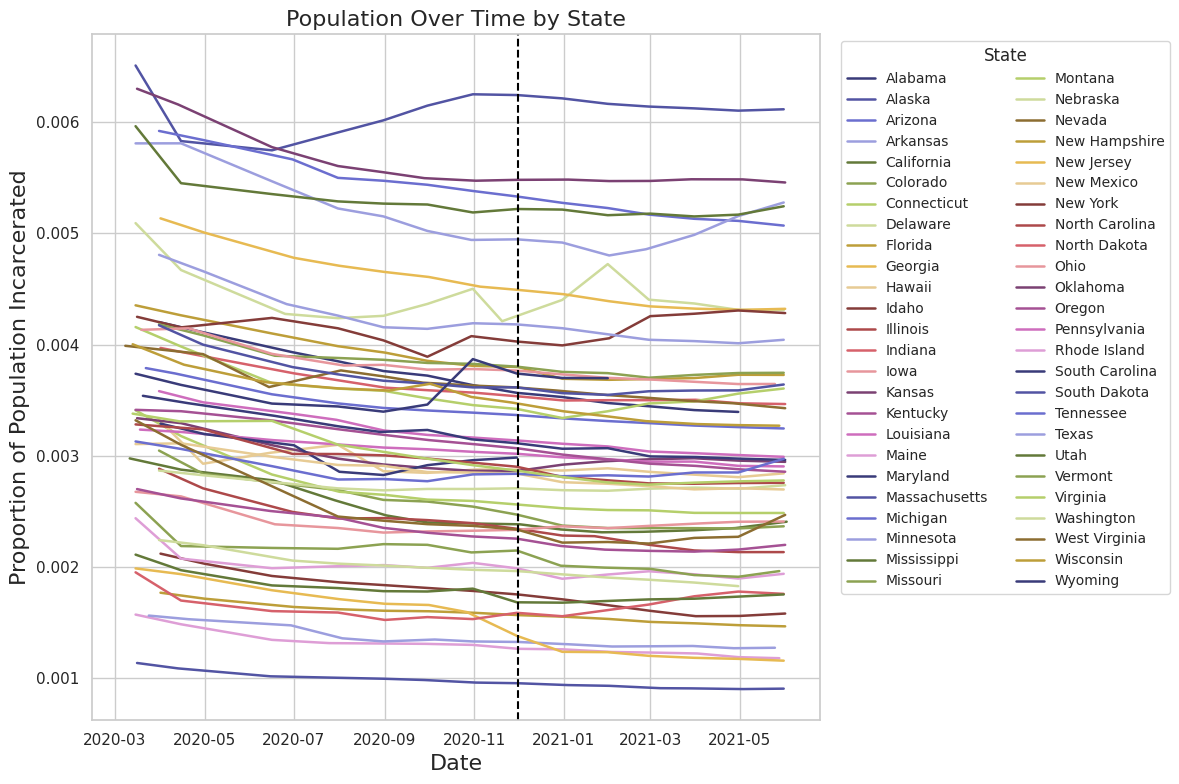

In [151]:
df_pops = pd.read_csv('Data/Cleaned/state_pops.csv')
df_pops['Date'] = pd.to_datetime(df_pops['Date'])
df_pops['pop'] = pd.to_numeric(df_pops['pop'], errors='coerce')
df_pops = df_pops[df_pops['Date'] >= '2020-03-01']
# Set style
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))

# Use a high-contrast colormap
unique_states = sorted(df_pops['name'].unique())
unique_states = [s for s in unique_states if s != 'Federal']
palette = sns.color_palette('tab20b', n_colors=len(unique_states))

# Plot lines
for i, (state, group) in enumerate(df_pops.groupby('name')):
    if state != 'Federal':
        pop = state_populations_2020[state]
        plt.plot(group['Date'], group['pop'] / pop, label=state, linewidth=1.8, color=palette[i % len(palette)])

# Improve plot labels
plt.title('Population Over Time by State', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Proportion of Population Incarcerated', fontsize=16)
plt.axvline(pd.to_datetime('December 1 2020'), color='black', linestyle='--', linewidth=1.5)
# Tidy, scrollable legend
plt.legend(title='State', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small', ncol=2, frameon=True)
plt.tight_layout()
plt.savefig('population_over_time.png')


In [152]:
 ###########

df = pd.read_csv(wd+'/Data/Cleaned/UCLA_statewide_temporal.csv')

df.Date = pd.to_datetime(df.Date)
df = df[(df.Date > '11-28-2021') & (df.Date < '12-06-2021')]##week 48 of 2021

# create not vaccinated column (this is needed for the glm model)
df['Residents.NotInitiated'] = df['Population_Dec2021'] - df['Residents.Initiated']


# get non-inc coverage
df_noninc=pd.read_csv(wd+'Data/Cleaned/data_county_timeseries.csv')
df_noninc=df_noninc.loc[df_noninc['CASE_TYPE']=='Partial']
df_noninc=df_noninc.loc[df_noninc['WEEK']==48] # December 1st week
df_noninc=df_noninc.loc[df_noninc['YEAR']==2021]
df_noninc = df_noninc.groupby('STATE_NAME')[['CASES', 'POPN']].sum().reset_index()
df_noninc['State']=df_noninc['STATE_NAME'].replace(states_abbrevs)
df_noninc['Non-Incarcerated Coverage'] = df_noninc['CASES']/df_noninc['POPN']
df_noninc = df_noninc[['State', 'Non-Incarcerated Coverage','STATE_NAME']]
#print(df_noninc.head())
df = df.merge(df_noninc, on='State',how='outer')

# make dataset smaller-- just keep what we need
df = df[['State', 'Residents.Initiated', 'Residents.NotInitiated', 'Non-Incarcerated Coverage','Date_prioritized','STATE_NAME']]





# drop any rows with NAs (drops Minnesota)
#df = df.loc[df['State']!='Minnesota']
df


,State,Residents.Initiated,Residents.NotInitiated,Non-Incarcerated Coverage,Date_prioritized,STATE_NAME
0,Alabama,12087.0,6192.0,0.528682,2021-04-01,AL
1,Alaska,2963.0,1766.0,0.609991,2021-02-01,AK
2,Arizona,NaN,NaN,0.633420,NaN,AZ
3,Arkansas,NaN,NaN,0.533683,NaN,AR
4,California,81561.0,18240.0,0.704373,2021-03-01,CA
5,Colorado,12414.0,1857.0,0.795482,NaN,CO
6,Connecticut,5003.0,4528.0,0.832608,NaN,CT
7,Delaware,NaN,NaN,0.707149,NaN,DE
8,District of Columbia,NaN,NaN,0.795035,NaN,DC
9,Federal,113767.0,34455.0,NaN,NaN,NaN


In [153]:

##Get decarceration percentage

decar_amount=pd.DataFrame(columns=['State','Decarceration'])
file_decar=open(wd+'/Data/Cleaned/state_pops.csv')
df_pops=pd.read_csv(file_decar)
df_pops1=df_pops
df_pops['Date']=pd.to_datetime(df_pops['Date'])
df_pops = df_pops[(df_pops['Date'] >= '2020-11-30') & (df_pops['Date'] <= '2020-12-06')] ##Identifies Week 49 of 2020

for state in df_pops['name'].unique():
    df_pop_state=df_pops.loc[df_pops['name']==state].reset_index()
    decar=df_pop_state['pop_change'][0]
    df2 = pd.DataFrame({'State':[state],'Decarceration':[decar]})

    decar_amount = pd.concat([decar_amount, df2], ignore_index=True)

decar_amount

df_pops1

<ipython-input-153-57bb6cb653cc>:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  decar_amount = pd.concat([decar_amount, df2], ignore_index=True)


,Unnamed: 0,index,name,abbreviation,month,pop,Date,year,pop_change
0,0,700,Wyoming,WY,3,2156,2020-03-15,2020,0.000000
1,1,701,Wyoming,WY,4,2098,2020-04-15,2020,-0.026902
2,2,702,Wyoming,WY,6,2001,2020-06-16,2020,-0.071892
3,3,703,Wyoming,WY,7,1986,2020-07-31,2020,-0.078850
4,4,704,Wyoming,WY,8,1959,2020-08-31,2020,-0.091373
...,...,...,...,...,...,...,...,...,...
709,709,9,Alabama,AL,1,17454,2021-01-31,2021,-0.173345
710,710,10,Alabama,AL,2,17308,2021-02-28,2021,-0.180260
711,711,11,Alabama,AL,3,17134,2021-03-31,2021,-0.188501
712,712,12,Alabama,AL,4,17051,2021-04-30,2021,-0.192432


In [154]:
df=df.merge(decar_amount,on='State',how='outer')

df=df.reset_index()
df['Decarceration']=df['Decarceration']*(-1)

In [155]:
df['Incentive']=0
df['Incentive'].loc[df['State'].isin(['Alabama','Mississippi','Hawaii','North Carolina','Pennsylvania','New York','Maryland','Virginia'])]=1
df=df.set_index('State')
df

<ipython-input-155-56cde9db3a26>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Incentive'].loc[df['State'].isin(['Alabama','Mississippi','Hawaii','North Carolina','Pennsylvania','New York','Maryland','Virginia'])]=1
<ipython-input-155

,index,Residents.Initiated,Residents.NotInitiated,Non-Incarcerated Coverage,Date_prioritized,STATE_NAME,Decarceration,Incentive
State,,,,,,,,
Alabama,0,12087.0,6192.0,0.528682,2021-04-01,AL,0.151558,1
Alaska,1,2963.0,1766.0,0.609991,2021-02-01,AK,0.040829,0
Arizona,2,NaN,NaN,0.633420,NaN,AZ,0.099599,0
Arkansas,3,NaN,NaN,0.533683,NaN,AR,0.148677,0
California,4,81561.0,18240.0,0.704373,2021-03-01,CA,0.199424,0
Colorado,5,12414.0,1857.0,0.795482,NaN,CO,0.189252,0
Connecticut,6,5003.0,4528.0,0.832608,NaN,CT,0.248739,0
Delaware,7,NaN,NaN,0.707149,NaN,DE,NaN,0
District of Columbia,8,NaN,NaN,0.795035,NaN,DC,NaN,0


In [156]:
file_general=open(wd+'Data/Cleaned/General_public_stats.csv')

df_general=pd.read_csv(file_general)

df_general=df_general.set_index('State')

df=df.merge(df_general,left_index=True, right_index=True,how='outer')

df['General_public']=pd.to_datetime(df['General_public'],format='%m/%d/%Y')

df['Date_prioritized']=pd.to_datetime(df['Date_prioritized'],format='%Y-%m-%d')

df['Days Prioritized']=''



for i, row in df.iterrows():
    if df.at[i,'Date_prioritized']!=pd.NaT:
        df.at[i,'Days Prioritized'] = (df.at[i,'General_public'] - df.at[i,'Date_prioritized']).days
    else:
        df.at[i,'Days Prioritized']=0
        df.at[i,'Prioritized']=0
df['Days Prioritized']=df['Days Prioritized'].fillna(0)
df=df.rename(columns={"Non-Incarcerated Coverage": "Non-Incarcerated \n Coverage"})
df=df.rename(columns={"Days Prioritized": "Days \n Prioritized"})
df.to_csv('Data/Cleaned/pre_regression.csv')
df

<ipython-input-156-0319fb16b609>:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Days Prioritized']=df['Days Prioritized'].fillna(0)


,index,Residents.Initiated,Residents.NotInitiated,Non-Incarcerated \n Coverage,Date_prioritized,STATE_NAME,Decarceration,Incentive,General_public,Days \n Prioritized
State,,,,,,,,,,
Alabama,0,12087.0,6192.0,0.528682,2021-04-01,AL,0.151558,1,2021-04-05,4
Alaska,1,2963.0,1766.0,0.609991,2021-02-01,AK,0.040829,0,2021-03-09,36
Arizona,2,NaN,NaN,0.633420,NaT,AZ,0.099599,0,2021-03-24,0
Arkansas,3,NaN,NaN,0.533683,NaT,AR,0.148677,0,2021-03-30,0
California,4,81561.0,18240.0,0.704373,2021-03-01,CA,0.199424,0,2021-04-15,45
Colorado,5,12414.0,1857.0,0.795482,NaT,CO,0.189252,0,2021-04-02,0
Connecticut,6,5003.0,4528.0,0.832608,NaT,CT,0.248739,0,2021-04-01,0
Delaware,7,NaN,NaN,0.707149,NaT,DE,NaN,0,2021-04-06,0
District of Columbia,8,NaN,NaN,0.795035,NaT,DC,NaN,0,NaT,0


In [157]:
# response
df_proper = df[df['Residents.Initiated'].notna()]
df_proper = df_proper[df_proper['Residents.NotInitiated'].notna()]
df_proper=df_proper.loc[~df_proper.index.isin(['Federal','Wisconsin'])]


df_response = df_proper[['Residents.Initiated', 'Residents.NotInitiated']]

#covariates
df_covariates = df_proper[["Non-Incarcerated \n Coverage", "Days \n Prioritized", 'Decarceration','Incentive']]

# standardize covariates
for col_name in df_covariates.columns:
    # Check if standard deviation is 0 to avoid division by zero
    std_dev = df_covariates[col_name].std()
    if std_dev == 0:
        # Handle the case where standard deviation is 0, e.g., set it to a small value
        std_dev = 1e-6  # Or another appropriate value
    df_covariates[col_name] = (df_covariates[col_name])/std_dev
    print(col_name,std_dev)
glm_binom = sma.GLM(df_response, df_covariates, family=sma.families.Binomial())
res = glm_binom.fit()
print(res.summary())

Non-Incarcerated 
 Coverage 0.11486696016560786
Days 
 Prioritized 36.7214901148811
Decarceration 0.07659647134997692
Incentive 0.41885390829169555
                                 Generalized Linear Model Regression Results                                 
Dep. Variable:     ['Residents.Initiated', 'Residents.NotInitiated']   No. Observations:                   19
Model:                                                           GLM   Df Residuals:                       15
Model Family:                                               Binomial   Df Model:                            3
Link Function:                                                 Logit   Scale:                          1.0000
Method:                                                         IRLS   Log-Likelihood:                -6642.8
Date:                                               Mon, 12 May 2025   Deviance:                       13108.
Time:                                                       17:02:21   Pearson chi

<ipython-input-157-708ac6bdfc72>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covariates[col_name] = (df_covariates[col_name])/std_dev


In [158]:
df_covariates

,Non-Incarcerated \n Coverage,Days \n Prioritized,Decarceration,Incentive
State,,,,
Alabama,4.602560,0.108928,1.978658,2.387467
Alaska,5.310415,0.980352,0.533042,0.000000
California,6.132078,1.225440,2.603562,0.000000
Colorado,6.925247,0.000000,2.470769,0.000000
Connecticut,7.248456,0.000000,3.247393,0.000000
Idaho,4.333860,0.953120,0.683172,0.000000
Kansas,5.401718,2.369185,1.858974,0.000000
Maine,6.881029,0.000000,2.564678,0.000000
Maryland,6.647139,0.136160,1.213383,2.387467


In [159]:
import geopandas
states = geopandas.read_file(wd+'Data/States_shapefile.shx')
#gdf = geopandas.GeoDataFrame(df)
states['State']=["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware","District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]

#states=states.loc[(states['State'] != 'Alaska')&(states['State'] != 'Hawaii')]
df_maps=pd.DataFrame(states)
df_maps=df_maps.merge(df,on='State',how='outer')
df_maps['Incentive']=df_maps['Incentive'].fillna(0)
df_maps['Incentive']=df_maps['Incentive'].replace({1.0:'Incentives',0.0:'No Incentives'})
df_maps

,geometry,State,index,Residents.Initiated,Residents.NotInitiated,Non-Incarcerated \n Coverage,Date_prioritized,STATE_NAME,Decarceration,Incentive,General_public,Days \n Prioritized
0,"POLYGON ((-85.07007 31.9807, -85.11515 31.9074...",Alabama,0,12087.0,6192.0,0.528682,2021-04-01,AL,0.151558,Incentives,2021-04-05,4
1,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",Alaska,1,2963.0,1766.0,0.609991,2021-02-01,AK,0.040829,No Incentives,2021-03-09,36
2,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",Arizona,2,NaN,NaN,0.633420,NaT,AZ,0.099599,No Incentives,2021-03-24,0
3,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",Arkansas,3,NaN,NaN,0.533683,NaT,AR,0.148677,No Incentives,2021-03-30,0
4,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",California,4,81561.0,18240.0,0.704373,2021-03-01,CA,0.199424,No Incentives,2021-04-15,45
5,"POLYGON ((-102.04446 37.64147, -102.04201 37.3...",Colorado,5,12414.0,1857.0,0.795482,NaT,CO,0.189252,No Incentives,2021-04-02,0
6,"POLYGON ((-73.53039 41.52275, -73.51715 41.665...",Connecticut,6,5003.0,4528.0,0.832608,NaT,CT,0.248739,No Incentives,2021-04-01,0
7,"POLYGON ((-75.70707 38.55759, -75.71071 38.649...",Delaware,7,NaN,NaN,0.707149,NaT,DE,NaN,No Incentives,2021-04-06,0
8,"POLYGON ((-77.00793 38.96667, -76.9109 38.8901...",District of Columbia,8,NaN,NaN,0.795035,NaT,DC,NaN,No Incentives,NaT,0
9,None,Federal,9,113767.0,34455.0,NaN,NaT,NaN,0.158855,No Incentives,NaT,0


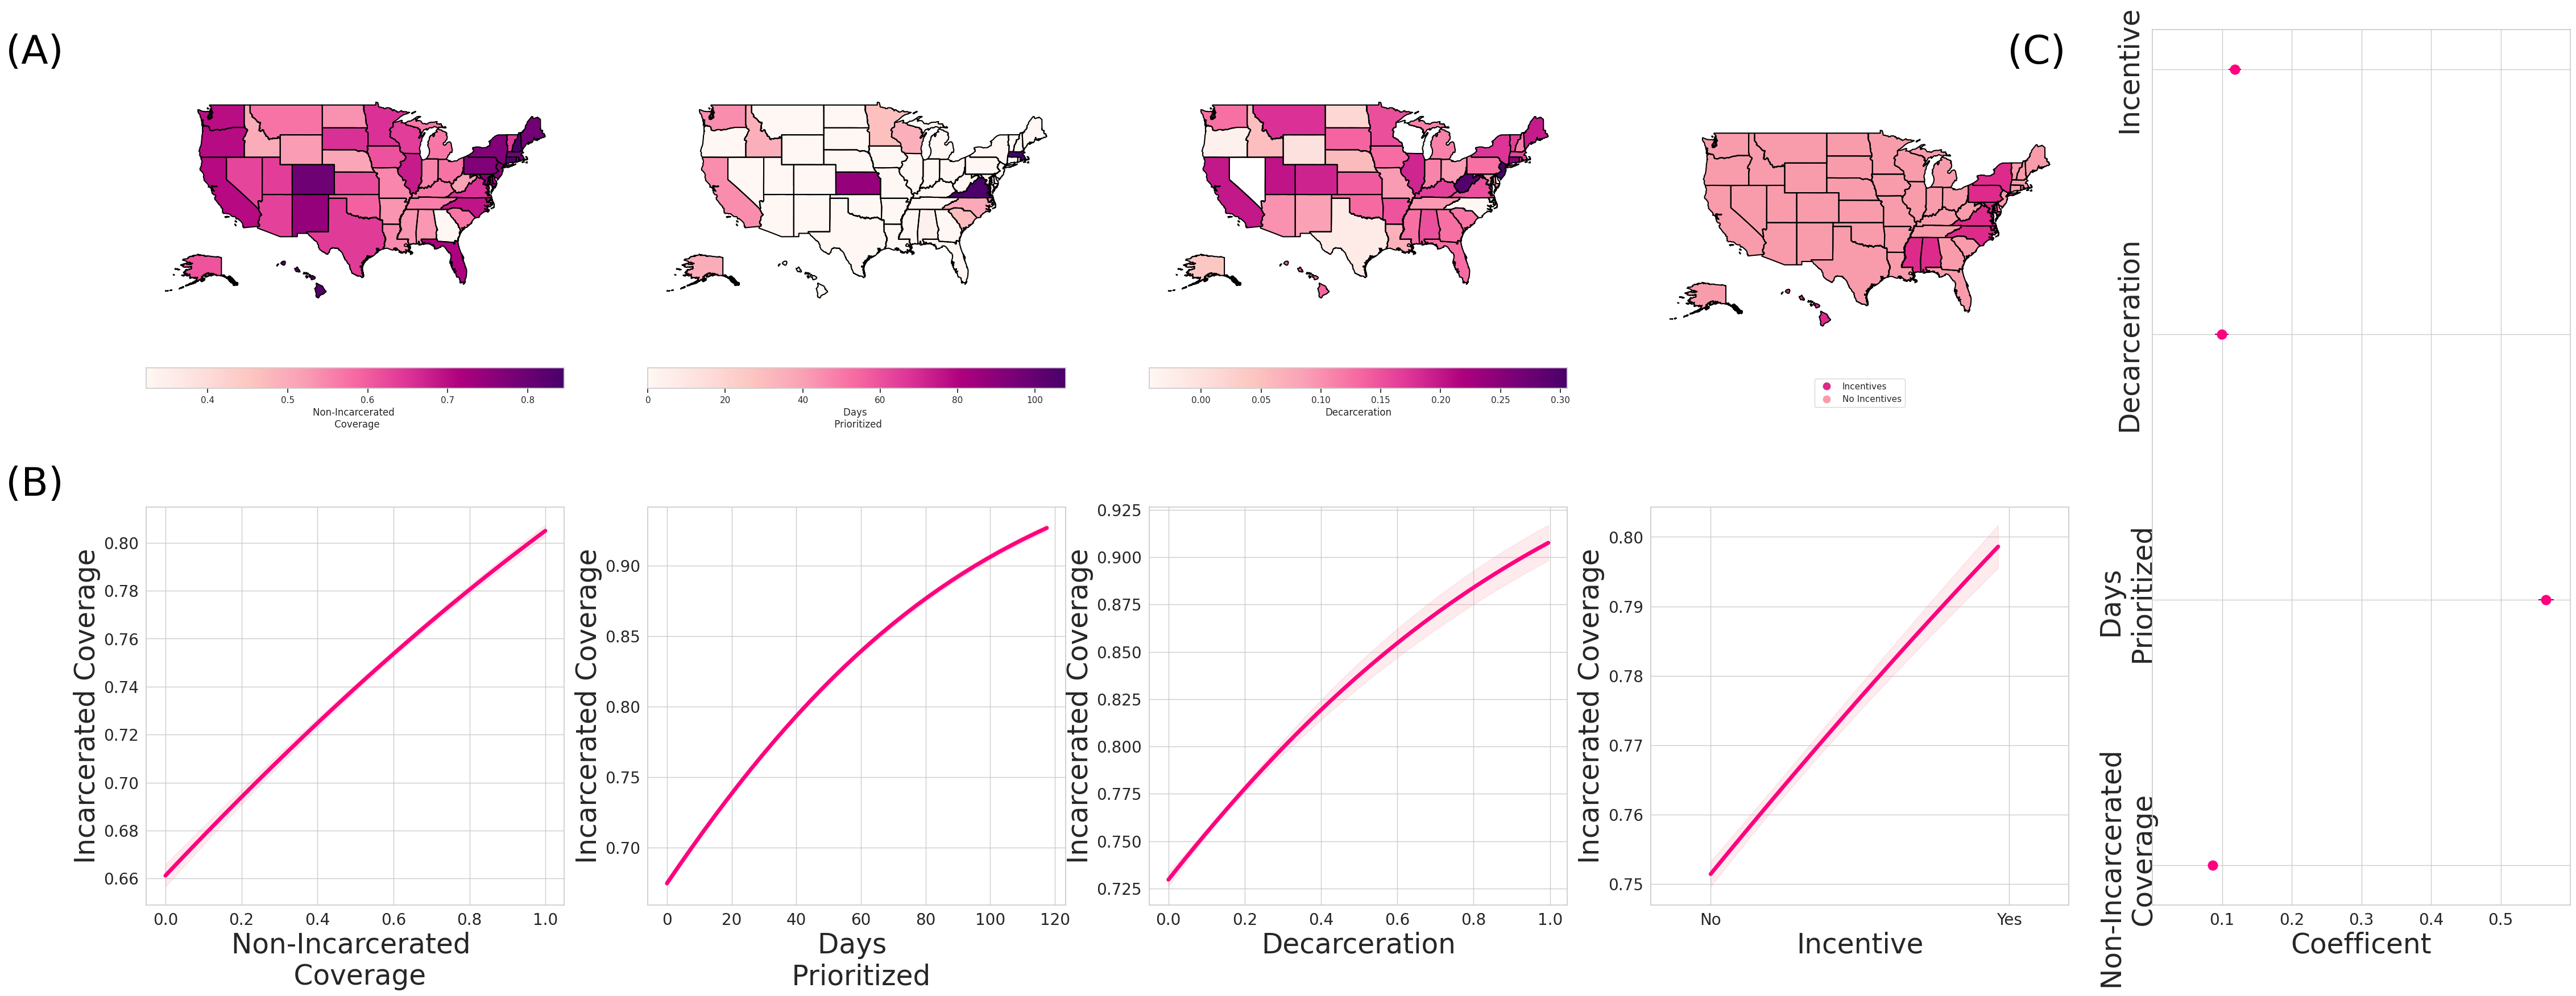

In [180]:
rates=[]
states= geopandas.GeoDataFrame(df_maps, crs="EPSG:4326",geometry='geometry')
from shapely import affinity
# Reposition Alaska and Hawaii

def reposition_states(gdf):
    alaska = gdf[gdf['State'] == 'Alaska']
    hawaii = gdf[gdf['State'] == 'Hawaii']
    continental = gdf[~gdf['State'].isin(['Alaska', 'Hawaii'])]

    alaska = alaska.copy()
    alaska.geometry = alaska.geometry.apply(lambda geom: affinity.translate(
        affinity.scale(geom, xfact=0.25, yfact=0.25, origin='center'),
        xoff=30, yoff=-35))  # side-by-side with Hawaii

    # Transform Hawaii: scale and position next to Alaska
    hawaii = hawaii.copy()
    hawaii.geometry = hawaii.geometry.apply(lambda geom: affinity.translate(
        affinity.scale(geom, xfact=1.5, yfact=1.5, origin='center'),
        xoff=50, yoff=5))

    return pd.concat([continental, alaska, hawaii])

states = reposition_states(states)
# MARGINAL EFFECT PLOT
grid = (2, 5)
df_plot=df[['Residents.NotInitiated','Residents.Initiated',"Non-Incarcerated \n Coverage", "Days \n Prioritized", 'Decarceration','Incentive']].dropna(subset=['Residents.NotInitiated','Residents.Initiated','Decarceration'])
df_plot=df_plot[["Non-Incarcerated \n Coverage", "Days \n Prioritized", 'Decarceration','Incentive']]
df_plot=df_plot.loc[df_plot.index!='Federal']

fig = plt.figure(figsize=(55, 20))  # or whatever

#ax = plt.subplot2grid(grid, (0,4), rowspan=2,colspan=1)  # left column plot
graph1 = plt.subplot2grid(grid, (1, 0))  # right column upper plot
graph2 = plt.subplot2grid(grid, (1, 1))  # right column lower plot
graph3 = plt.subplot2grid(grid, (1, 2))  # right column upper plot
graph4 = plt.subplot2grid(grid, (1, 3))  # right column upper plot

map1 = plt.subplot2grid(grid, (0, 0))  # right column upper plot
map2 = plt.subplot2grid(grid, (0, 1))  # right column lower plot
map3 = plt.subplot2grid(grid, (0, 2))  # right column upper plot
map4 = plt.subplot2grid(grid, (0, 3))  # right column upper plot

axes=[graph1,graph2,graph3,graph4]
maps=[map1,map2,map3,map4]

######################################PLOTTING COVARIATE VS INCARCERATED COVERAGE##############################################################
# make a marginal effect plot for each covariate
for num in range(0,4):
    col_name=df_covariates.columns[num]
    ax=axes[num]
    # create a list of covariate names, excluding col_name
    other_col_names = list(df_covariates.columns)
    other_col_names.remove(col_name)
    ###################################
    # create hypothetical range of covariates
    # for col_name, we want to explore the range of values this variable can take
    # for other covariates, we want to fix them at their mean value
    X_range = pd.DataFrame(columns = df_covariates.columns)
    if col_name=='Days \n Prioritized':
      X_range[col_name] = np.arange(0,120/df_plot[col_name].std(), 0.1)
    else:
      X_range[col_name] = np.arange(0,1/df_plot[col_name].std(), 0.1)


    for other_col in other_col_names:
      X_range[other_col] = df_covariates[other_col].mean()

    ###################################
    # Get the predicted values and standard errors for the range of x values
    y_pred = res.predict(X_range)
    y_std = res.get_prediction(X_range).se_mean

    ###################################
    # Plot the data and regression line with confidence intervals

    # since we had standardized the x values by their std, we need to undo that so that the plot shows the right value
    x_plot = X_range[col_name]*df_plot[col_name].std()
    rates.append([list(zip(x_plot,y_pred))])
    ax.plot(x_plot, y_pred, color='#ff007f',linewidth=5)
    if col_name=='Days \n Prioritized':
        ax.fill_between(x_plot, y_pred - stats.t.ppf(q=0.975,df=len(X_range)-3) * y_std, y_pred + stats.t.ppf(q=0.975,df=len(X_range)-3) * y_std, color='#f89cab', alpha=0.2)
    else:
        ax.fill_between(x_plot, y_pred - stats.t.ppf(q=0.975,df=len(X_range)-3) * y_std, y_pred + stats.t.ppf(q=0.975,df=len(X_range)-3) * y_std, color='#f89cab', alpha=0.2)
    ax.set_ylabel('Incarcerated Coverage',fontsize=35)
    ax.set_xlabel(col_name,fontsize=35)
    ax.tick_params(axis='x', labelsize=20)
    if col_name=='Incentive':
      ax.set_xlim([-0.2,1.2])
      ax.set_xticks([0,1], labels=['No','Yes'], fontsize=20)
    ax.tick_params(axis='y', labelsize=20)

###############################################MAPPING POLICY IMPLEMENTATION #####################################################################
    states.set_crs(epsg='4326')
    states.boundary.plot(color='black',ax=maps[num])
    states=states.loc[states['Non-Incarcerated \n Coverage']!=np.inf]
    if col_name=='Incentive':
      from matplotlib.colors import ListedColormap
      custom_cmap = ListedColormap(['#de2a8a','#f89cab'])
      map=states.plot(column=col_name,cmap=custom_cmap,ax=maps[num],legend='True',categorical=True,legend_kwds={"loc": "lower center","bbox_to_anchor": (0.5, -0.35)})
      map.axis("off")
    else:

      map=states.plot(column=col_name,cmap='RdPu',ax=maps[num],legend='True', legend_kwds={"label": col_name, "orientation": "horizontal"})
      map.axis("off")
    plt.rcParams.update({'font.size': 35})

##################################################PLOTTING REGRESSION COEFFICIENTS################################################################
ax = plt.subplot2grid(grid, (0,4), rowspan=2,colspan=1)  # left column plot
err_series = res.params - res.conf_int()[0]
coef_df = pd.DataFrame({'coef': res.params.values[0:],
                        'err': err_series.values[0:],
                        'varname': err_series.index.values[0:]
                       })
#ax.set_xticks(x_plot,fontsize=12)
summary = res.summary()
results_df = pd.DataFrame(summary.tables[1].data)
results_df.columns = results_df.iloc[0]
results_df=results_df.iloc[1:5]


#coef_df.plot(x='coef', y='varname', kind='bar',
         #    ax=ax, color='none',
         #    yerr='err', legend=False)



#ax.scatter(x=coef_df['coef'],
    #       marker='s', s=100,
    #       y=pd.np.arange(coef_df.shape[0]), color='black')

results_df['[0.025']=results_df['coef'].astype(float)-results_df['[0.025'].astype(float)
results_df['0.975]']=results_df['0.975]'].astype(float)-results_df['coef'].astype(float)




xerr=np.array([(results_df.iloc[0]['[0.025'],results_df.iloc[0]['0.975]']),
      (results_df.iloc[1]['[0.025'],results_df.iloc[1]['0.975]']),
      (results_df.iloc[2]['[0.025'],results_df.iloc[2]['0.975]']),
      (results_df.iloc[3]['[0.025'],results_df.iloc[3]['0.975]'])],dtype='float64').T

y=np.arange(coef_df.shape[0])

plt.errorbar(x=coef_df['coef'], y=np.arange(coef_df.shape[0]), xerr=xerr, fmt='o',color='#ff007f',ecolor='purple',markersize=12)

#ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
#ax.yaxis.set_ticks_position('none')



ax.set_xlabel('Coefficent',fontsize=35)
ax.set_yticks(y)
labels=list(df_covariates.columns)
labels=[s + '\n' for s in labels]
ax.set_yticklabels(labels,rotation=90, fontsize=35,va='center',ha='center')
ax.tick_params(axis='x', labelsize=20)
ax.set_xlim(0,0.6)
ax.set_xticks(np.arange(0.1,0.6,0.1))
#ax.set_xticks(np.arange(min(x_plot), max(x_plot)+0.1,0.1))




fig.text(0.08, 0.85,
         '(A)',
         fontsize = 50,
         color = "black")
fig.text(0.08, 0.47,
         '(B)',
         fontsize = 50,
         color = "black")
fig.text(0.72, 0.85,
         '(C)',
         fontsize = 50,
         color = "black")


plt.show()
fig.savefig(wd+'/Regression Model.jpg')


##CHANGES:
#incentive ones to zero one
##marginal effect plots without incarcerated coverage

In [171]:
vif_data = pd.DataFrame()
vif_data["covariate"] = df_covariates.columns

# calculating VIF for each feature
vif_data["VIF"] =[variance_inflation_factor(df_covariates.values, i) for i in range(len(df_covariates.columns))]

print(vif_data)

                      covariate       VIF
0  Non-Incarcerated \n Coverage  6.220488
1           Days \n Prioritized  1.662380
2                 Decarceration  4.756533
3                     Incentive  1.402538


In [172]:
states[['State','Non-Incarcerated \n Coverage']]

,State,Non-Incarcerated \n Coverage
0,Alabama,0.528682
2,Arizona,0.633420
3,Arkansas,0.533683
4,California,0.704373
5,Colorado,0.795482
6,Connecticut,0.832608
7,Delaware,0.707149
8,District of Columbia,0.795035
9,Federal,NaN
10,Florida,0.713534


In [173]:
prioritization=rates[1][0]

days,incar_cov = zip(*prioritization)
days=days[0:27]
incar_cov_60=incar_cov[0:27]


non_inc=rates[0][0]
non_inc,incar_cov = zip(*non_inc)

decar=rates[2][0]
decar,incar_cov_decar = zip(*decar)

In [174]:
def slope(x, y):
    if len(x) != len(y):
        raise ValueError("Lists must be the same length")

    n = len(x)
    x_mean = sum(x) / n
    y_mean = sum(y) / n

    numerator = sum((x[i] - x_mean) * (y[i] - y_mean) for i in range(n))
    denominator = sum((x[i] - x_mean) ** 2 for i in range(n))

    if denominator == 0:
        raise ValueError("Cannot calculate slope, denominator is zero")

    return numerator / denominator

print(slope(days,incar_cov_60)*10*100)
print(slope(non_inc,incar_cov)/10*100)
print(slope(decar,incar_cov_decar)/10*100)
df

2.357824125664282
1.4409036719080666
1.7795718911109224


,index,Residents.Initiated,Residents.NotInitiated,Non-Incarcerated \n Coverage,Date_prioritized,STATE_NAME,Decarceration,Incentive,General_public,Days \n Prioritized
State,,,,,,,,,,
Alabama,0,12087.0,6192.0,0.528682,2021-04-01,AL,0.151558,1,2021-04-05,4
Alaska,1,2963.0,1766.0,0.609991,2021-02-01,AK,0.040829,0,2021-03-09,36
Arizona,2,NaN,NaN,0.633420,NaT,AZ,0.099599,0,2021-03-24,0
Arkansas,3,NaN,NaN,0.533683,NaT,AR,0.148677,0,2021-03-30,0
California,4,81561.0,18240.0,0.704373,2021-03-01,CA,0.199424,0,2021-04-15,45
Colorado,5,12414.0,1857.0,0.795482,NaT,CO,0.189252,0,2021-04-02,0
Connecticut,6,5003.0,4528.0,0.832608,NaT,CT,0.248739,0,2021-04-01,0
Delaware,7,NaN,NaN,0.707149,NaT,DE,NaN,0,2021-04-06,0
District of Columbia,8,NaN,NaN,0.795035,NaT,DC,NaN,0,NaT,0


In [164]:



# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    y='Incarcerated_Coverage',
    x='NonIncarcerated_Coverage',
    color='purple',  # Set color for all states to purple
    legend=False,
    s=100,  # Adjust marker size for better visibility
    alpha=0.7,  # Adjust transparency to make points clearer
    marker='o'  # Use a circular marker
)

# Add the dashed line for x = y, but limit the line to the relevant section
plt.plot([0.45, 1], [0.45, 1], 'k--', label="x = y")  # 'k--' creates a black dashed line

# Title and labels
plt.title("Incarcerated vs. Non-Incarcerated Vaccination Coverage in December 2021", fontsize=16)
plt.ylabel("Incarcerated Coverage",fontsize=16)
plt.xlabel("Non-Incarcerated Coverage",fontsize=16)
plt.xlim(0.45, 1)
plt.ylim(0.45, 1)

# Grid and layout
plt.grid(True)
#plt.tight_layout()

# Show the plot
plt.savefig('vaccination_coverage_scatterplot.png', dpi=1000)

ValueError: Could not interpret value `NonIncarcerated_Coverage` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x800 with 0 Axes>

In [ ]:
df_proper.loc[df_proper['Incentive']==1]